In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import norm

## Load results of MC simulation

In [2]:
with open('results_dict_simple.pkl', 'rb') as pickle_file:
    results_dict_ = pickle.load(pickle_file)

In [3]:
results_dict = {}

for N, results in results_dict_.items():
    ate_estimates, sigma_estimates, CIs, _ = results
    results_dict[N] = [ate_estimates[:, :4], sigma_estimates, CIs]

## Assess convergence rates and asymptotic properties

In [4]:
theta_0 = 1.0   # true ATE
sample_sizes = list(results_dict.keys())
colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:orange']
names = ['Oracle', 'No cross-fitting', '2-fold DML', '5-fold DML']

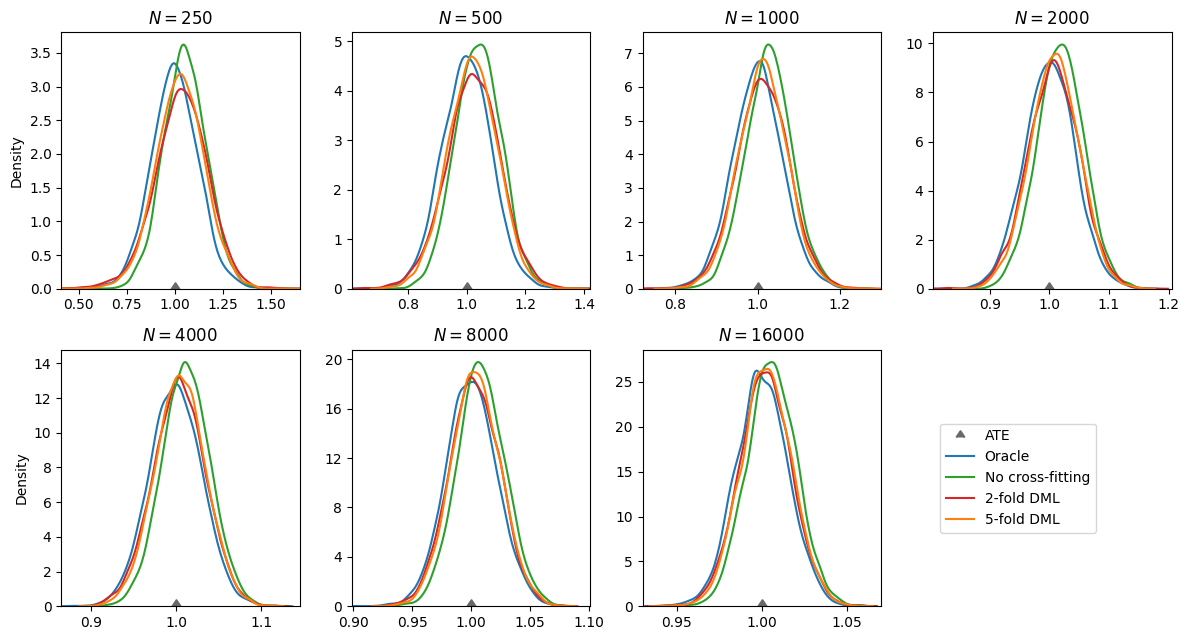

In [5]:
# Visual comparison of estimators
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6.5))

for i, (N, results) in enumerate(results_dict.items()):
    ax = axes.flat[i]
    ax.scatter(theta_0, 0, marker=10, color='dimgrey', label='ATE')
    ate_estimates = results[0]
    for k in range(4):
        sns.kdeplot(ate_estimates[:,k], ax=ax, color=colors[k], label=names[k])
    ax.set_title(r'$N=$' + f'{N}')
    
    if not (i==0 or i==4):
        ax.set_ylabel('')
    if i==0:
        ax.set_xlim(left=0.41, right=1.65)
    elif i==1:
        ax.set_xlim(left=0.61, right=1.42)
    elif i==2:
        ax.set_xlim(left=0.72, right=1.3)
    elif i==3:
        ax.set_xlim(left=0.805, right=1.205)
    elif i==4:
        ax.set_xlim(left=0.865, right=1.145)
    elif i==5:
        ax.set_xlim(left=0.899, right=1.101)
        ax.set_yticks([0, 4, 8, 12, 16, 20])
    elif i==6:
        ax.set_xlim(left=0.93, right=1.07)
    if i==6: 
        handles, labels = ax.get_legend_handles_labels()

axes.flat[-1].legend(handles, labels, loc='center left', bbox_to_anchor=(0, 0.5))        
axes.flat[-1].axis('off')
fig.tight_layout()

for fmt in ['png', 'pdf']:
    fig.savefig(f'figures_2/Visual_comparison.{fmt}', dpi=300, bbox_inches='tight')

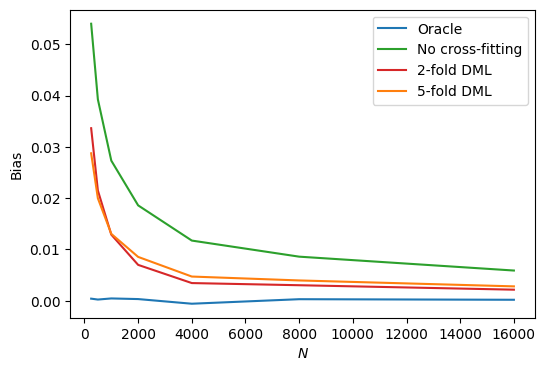

In [6]:
# Bias
bias = np.empty((len(sample_sizes), 4))

for i, (N, results) in enumerate(results_dict.items()):
    ate_estimates = results[0]
    bias[i] = np.mean(ate_estimates-theta_0, axis=0)

plt.figure(figsize=(6, 4))
for k in range(4):
    plt.plot(sample_sizes, bias[:,k], color=colors[k], label=names[k])
plt.xlabel(r'$N$')
plt.ylabel('Bias')
plt.legend()

for fmt in ['png', 'pdf']:
    plt.savefig(f'figures_2/Bias.{fmt}', dpi=300, bbox_inches='tight')

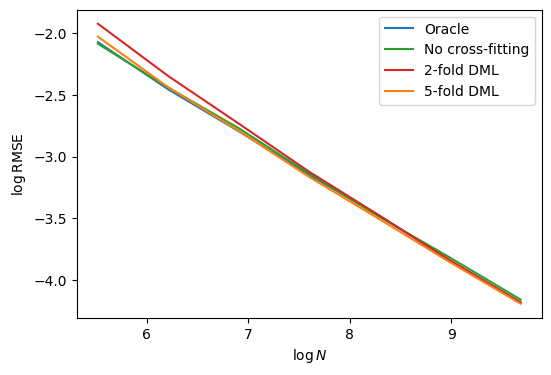

In [7]:
# Convergence rates
rmse = np.empty((len(sample_sizes), 4))

for i, (N, results) in enumerate(results_dict.items()):
    ate_estimates = results[0]
    rmse[i] = np.sqrt(np.mean((ate_estimates-theta_0)**2, axis=0))

plt.figure(figsize=(6, 4))
for k in range(4):
    plt.plot(np.log(sample_sizes), np.log(rmse[:,k]), color=colors[k], label=names[k])
plt.xlabel(r'$\log N$')
plt.ylabel(r'$\log$' + 'RMSE')
plt.legend()

for fmt in ['png', 'pdf']:
    plt.savefig(f'figures_2/Convergence_rates_1.{fmt}', dpi=300, bbox_inches='tight')

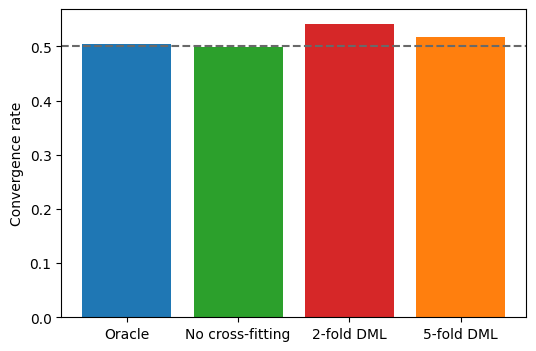

In [8]:
# Convergence rates
slopes = np.polyfit(np.log(sample_sizes), np.log(rmse), 1)[0,:]

plt.figure(figsize=(6, 4))
plt.bar(names, -slopes, color=colors)
plt.axhline(y=0.5, color='dimgrey', linestyle='--')
plt.ylabel('Convergence rate')

for fmt in ['png', 'pdf']:
    plt.savefig(f'figures_2/Convergence_rates_2.{fmt}', dpi=300, bbox_inches='tight')

In [9]:
-slopes

array([0.50390329, 0.49934086, 0.54135475, 0.51741012])

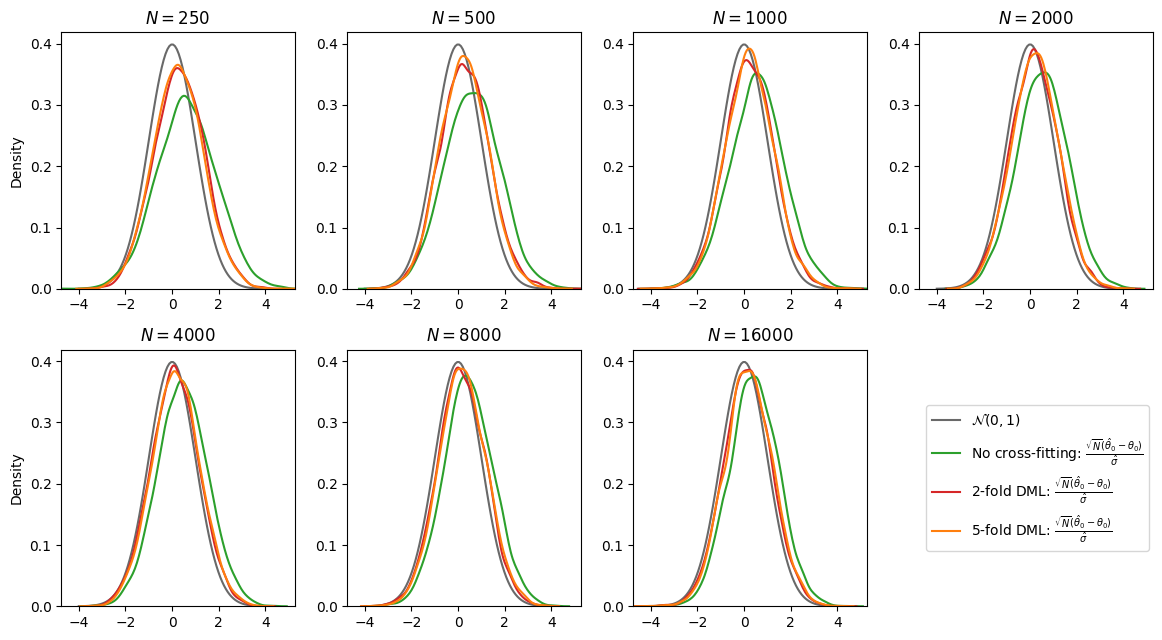

In [10]:
# Asymptotic normality
grid = np.linspace(-4, 4, 100)
pdf_values = norm.pdf(grid)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6.5))

for i, (N, results) in enumerate(results_dict.items()):
    ax = axes.flat[i]
    ate_estimates, sigma_estimates, _ = results
    ax.plot(grid, pdf_values, color='dimgrey', label=r'$\mathcal{N}(0,1)$')
    for k in [1, 2, 3]:
        sns.kdeplot(np.sqrt(N)*(ate_estimates[:,k]-theta_0)/sigma_estimates[:,k-1], ax=ax, color=colors[k], 
                    label=names[k]+r': $\frac{\sqrt{N}(\hat{\theta}_0-\theta_0)}{\hat{\sigma}}$')
    ax.set_xlim(left=-4.75, right=5.25)
    ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
    ax.set_title(r'$N=$' + f'{N}')
    
    if not (i==0 or i==4):
        ax.set_ylabel('')  
    if i==6: 
        handles, labels = ax.get_legend_handles_labels()
  
axes.flat[-1].legend(handles, labels, loc='center left', bbox_to_anchor=(0, 0.5))        
axes.flat[-1].axis('off')
fig.tight_layout()

for fmt in ['png', 'pdf']:
    fig.savefig(f'figures_2/Asymptotic_normality.{fmt}', dpi=300, bbox_inches='tight')

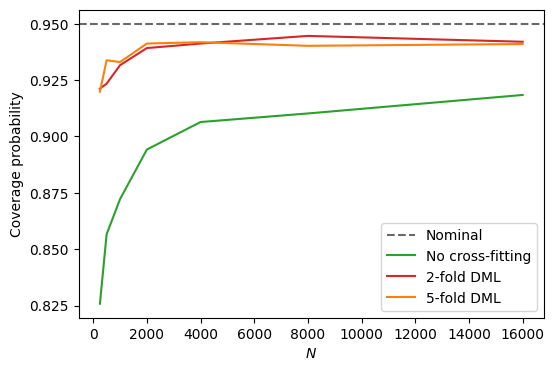

In [11]:
# Coverage probability
cov_prob = []
for results in results_dict.values():
    CIs = results[-1]
    cov_prob.append([])
    for k in [1, 2, 3]:
        cov_prob[-1].append(np.mean((theta_0>=CIs[:,2*k-2]) & (theta_0<=CIs[:,2*k-1])))
cov_prob = np.array(cov_prob)

plt.figure(figsize=(6, 4))
plt.axhline(y=0.95, color='dimgrey', linestyle='--', label='Nominal')
for k in [1, 2, 3]:
    plt.plot(sample_sizes, cov_prob[:,k-1], color=colors[k], label=names[k])
plt.xlabel(r'$N$')
plt.ylabel('Coverage probability')
plt.yticks([0.825, 0.850, 0.875, 0.900, 0.925, 0.950])
plt.legend()

for fmt in ['png', 'pdf']:
    plt.savefig(f'figures_2/Coverage_probability.{fmt}', dpi=300, bbox_inches='tight')